# LightGBM

Script com foco no processo de forecast com previsão multi-step. <br>Método: direct prediction (ver https://machinelearningmastery.com/multi-step-time-series-forecasting/)


In [1]:
#https://www.youtube.com/watch?v=fG8H-0rb0mY
#https://machinelearningmastery.com/light-gradient-boosted-machine-lightgbm-ensemble/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import lightgbm as lgb

In [2]:
plt.style.use('fivethirtyeight') # estilo dos gráficos
rcParams['figure.figsize'] = 15, 5 # tamanho das figuras

In [3]:
lgb.__version__

'3.3.2'

In [4]:
def load_data():
    """
    Função para ler e transformar os dados já presentes no diretório especificado
    """
    path = "../data/daily_load.csv"
    df_load = pd.read_csv(path, parse_dates = ["date"])
    df_load2 = df_load[df_load["id_reg"] == "S"]           # região sul
    df_load3 = df_load2[df_load2["date"] <= '2022-05-31']  # data de corte
    df_load4 = df_load3[["date", "load_mwmed"]].set_index("date")
    return df_load4

def train_test_split(data, n_test):
    """
    Função para partir or dados em treino e teste
    """
    if isinstance(data, pd.DataFrame):
        train, test = data.iloc[:-n_test, :], data.iloc[-n_test:, :]
    elif isinstance(data, np.ndarray):
        train, test = data[:-n_test, :], data[-n_test:, :]
    return train, test

# https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace = True)
    return agg

def lightgbm_forecast(train, testX):
	# transform list into array
	train = np.asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = lgb.LGBMRegressor(objective='regression', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = lightgbm_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected = %.1f, predicted = %.1f' % (testy, yhat))
    # estimate prediction error
    mae = mean_absolute_error(test[:, -1], predictions)
    mape = mean_absolute_percentage_error(test[:, -1], predictions)
    rmse = np.sqrt(mean_squared_error(test[:, -1], predictions))    
    return mae, mape, rmse, test[:, -1], predictions

def get_measures(forecast, test):
    """
    Função para obter medidas de acurária a partir dos dados de projeção e teste
    """
    #forecast.reset_index(drop = True, inplace = True)
    #test.reset_index(drop = True, inplace = True)
    #errors = [(test.iloc[i] - forecast.iloc[i])**2 for i in range(len(test))]
    if isinstance(forecast, pd.Series) and isinstance(test, pd.Series):
        errors = [(test.iloc[i] - forecast.iloc[i])**2 for i in range(len(test))]
    # else:
    #     errors = [(test.iloc[i][0] - forecast.iloc[i])**2 for i in range(len(test))]
    mae = mean_absolute_error(test, forecast)
    mse = mean_squared_error(test, forecast)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(test, forecast)
    # smape
    a = np.reshape(test.values, (-1,))
    b = np.reshape(forecast.values, (-1,))
    smape = np.mean(100*2.0 * np.abs(a - b) / (np.abs(a) + np.abs(b))).item()
    # dicionário com as medidas de erro
    measures = { "erro": sum(errors),
                 "mae": mae,
                 "mse": mse,
                 "rmse": rmse,
                 "mape": mape,
                 "smape": smape
                }
    # arredondamento
    # for key, item in measures.items():
    #     measures[key] = round(measures[key], 2)
    return measures


In [81]:
df = load_data()
df = df[df.index <= '2022-04-30']
values = df.values.tolist()
lag = 60 
outs = 5
data = series_to_supervised(values, n_in = lag, n_out = outs, dropnan=False)
data.tail(5)

,var1(t-60),var1(t-59),var1(t-58),var1(t-57),var1(t-56),var1(t-55),var1(t-54),var1(t-53),var1(t-52),var1(t-51),...,var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4)
8152,15101.339458,13219.668167,11890.958833,14121.620500,13533.691167,14360.921333,14522.455750,14725.693750,13204.445458,11716.236167,...,11325.166083,11635.152167,9745.995625,8676.435833,11917.185167,12640.413333,13018.601750,13048.245458,12261.400625,10444.075958
8153,13219.668167,11890.958833,14121.620500,13533.691167,14360.921333,14522.455750,14725.693750,13204.445458,11716.236167,14608.583292,...,11635.152167,9745.995625,8676.435833,11917.185167,12640.413333,13018.601750,13048.245458,12261.400625,10444.075958,NaN
8154,11890.958833,14121.620500,13533.691167,14360.921333,14522.455750,14725.693750,13204.445458,11716.236167,14608.583292,14834.671083,...,9745.995625,8676.435833,11917.185167,12640.413333,13018.601750,13048.245458,12261.400625,10444.075958,NaN,NaN
8155,14121.620500,13533.691167,14360.921333,14522.455750,14725.693750,13204.445458,11716.236167,14608.583292,14834.671083,14860.906667,...,8676.435833,11917.185167,12640.413333,13018.601750,13048.245458,12261.400625,10444.075958,NaN,NaN,NaN
8156,13533.691167,14360.921333,14522.455750,14725.693750,13204.445458,11716.236167,14608.583292,14834.671083,14860.906667,14877.019417,...,11917.185167,12640.413333,13018.601750,13048.245458,12261.400625,10444.075958,NaN,NaN,NaN,NaN


In [86]:
# EXEMPLO 1: t+2
# ÚLTIMO VALOR EM var1(t+h) DEVE SER O MESMO PARA TODAS ESTIMAÇÕES
# PARA VISUALIZAR MELHOR, OLHAR EXCEL "multistep" NA PASTA "DATA"
response_vars = data.columns[-outs:]
cols = [x for x in data.columns[:lag]]
cols.append("var1(t+3)")
data_ = data[cols]
data_.dropna(inplace = True) # retirar "na" só da coluna de t+h que está se estimando 
data_.tail(5)

C:\Users\user\AppData\Local\Temp\ipykernel_10032\1217042429.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_.dropna(inplace = True) # retirar "na" só da coluna de t+h que está se estimando


,var1(t-60),var1(t-59),var1(t-58),var1(t-57),var1(t-56),var1(t-55),var1(t-54),var1(t-53),var1(t-52),var1(t-51),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t+3)
8149,15088.180500,14903.538667,15048.168208,15101.339458,13219.668167,11890.958833,14121.620500,13533.691167,14360.921333,14522.455750,...,11381.112708,8310.664667,8604.080542,8044.328167,11133.275000,11832.275000,11905.543417,11325.166083,11635.152167,12640.413333
8150,14903.538667,15048.168208,15101.339458,13219.668167,11890.958833,14121.620500,13533.691167,14360.921333,14522.455750,14725.693750,...,8310.664667,8604.080542,8044.328167,11133.275000,11832.275000,11905.543417,11325.166083,11635.152167,9745.995625,13018.601750
8151,15048.168208,15101.339458,13219.668167,11890.958833,14121.620500,13533.691167,14360.921333,14522.455750,14725.693750,13204.445458,...,8604.080542,8044.328167,11133.275000,11832.275000,11905.543417,11325.166083,11635.152167,9745.995625,8676.435833,13048.245458
8152,15101.339458,13219.668167,11890.958833,14121.620500,13533.691167,14360.921333,14522.455750,14725.693750,13204.445458,11716.236167,...,8044.328167,11133.275000,11832.275000,11905.543417,11325.166083,11635.152167,9745.995625,8676.435833,11917.185167,12261.400625
8153,13219.668167,11890.958833,14121.620500,13533.691167,14360.921333,14522.455750,14725.693750,13204.445458,11716.236167,14608.583292,...,11133.275000,11832.275000,11905.543417,11325.166083,11635.152167,9745.995625,8676.435833,11917.185167,12640.413333,10444.075958


In [89]:
# EXEMPLO 2: t+4- PARA VISUALIZAR MELHOR, OLHAR EXCEL "multistep" NA PASTA "DATA"
# ÚLTIMO VALOR EM var1(t+h) DEVE SER O MESMO PARA TODAS ESTIMAÇÕES
# PARA VISUALIZAR MELHOR, OLHAR EXCEL "multistep" NA PASTA "DATA"
response_vars = data.columns[-outs:]
cols = [x for x in data.columns[:lag]]
cols.append("var1(t+4)")
data_ = data[cols]
data_.dropna(inplace = True) # retirar "na" só da coluna de t+h que está se estimando 
data_.tail(5)

C:\Users\user\AppData\Local\Temp\ipykernel_10032\2497736831.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_.dropna(inplace = True) # retirar "na" só da coluna de t+h que está se estimando


,var1(t-60),var1(t-59),var1(t-58),var1(t-57),var1(t-56),var1(t-55),var1(t-54),var1(t-53),var1(t-52),var1(t-51),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t+4)
8148,14721.577833,15088.180500,14903.538667,15048.168208,15101.339458,13219.668167,11890.958833,14121.620500,13533.691167,14360.921333,...,12080.641000,11381.112708,8310.664667,8604.080542,8044.328167,11133.275000,11832.275000,11905.543417,11325.166083,12640.413333
8149,15088.180500,14903.538667,15048.168208,15101.339458,13219.668167,11890.958833,14121.620500,13533.691167,14360.921333,14522.455750,...,11381.112708,8310.664667,8604.080542,8044.328167,11133.275000,11832.275000,11905.543417,11325.166083,11635.152167,13018.601750
8150,14903.538667,15048.168208,15101.339458,13219.668167,11890.958833,14121.620500,13533.691167,14360.921333,14522.455750,14725.693750,...,8310.664667,8604.080542,8044.328167,11133.275000,11832.275000,11905.543417,11325.166083,11635.152167,9745.995625,13048.245458
8151,15048.168208,15101.339458,13219.668167,11890.958833,14121.620500,13533.691167,14360.921333,14522.455750,14725.693750,13204.445458,...,8604.080542,8044.328167,11133.275000,11832.275000,11905.543417,11325.166083,11635.152167,9745.995625,8676.435833,12261.400625
8152,15101.339458,13219.668167,11890.958833,14121.620500,13533.691167,14360.921333,14522.455750,14725.693750,13204.445458,11716.236167,...,8044.328167,11133.275000,11832.275000,11905.543417,11325.166083,11635.152167,9745.995625,8676.435833,11917.185167,10444.075958


In [71]:
# DATA DA ÚLTIMA LINHA EM "data"
df[df.load_mwmed == data["var1(t)"].iloc[-1]]

,load_mwmed
date,
2022-04-30,10444.075958


In [56]:
i = None

In [49]:
# DIRECT PREDICTION

# lista com as variáveis resposta
response_vars = data.columns[-outs:]

# estimate models for every t + h
for response in response_vars:
    cols = [x for x in data.columns[:lag]] # features names. resets every iteration
    cols.append(response)
    data_ = data[cols]
    X, y = data_.iloc[:, :-1], data_.iloc[:, -1]    
    model = lgb.LGBMRegressor(objective='regression', n_estimators=1000)
    model.fit(X, y)
    yhat = model.predict([data_.iloc[-1, :-1].values])[0]
    yobs = y.iloc[-1] 
    print(f"> expected: {yobs}, predicted: {yhat}")

> expected: 10444.07595833, predicted: 10423.300175959055
> expected: 8794.163125, predicted: 8776.545853490734
> expected: 11643.82154167, predicted: 11660.587035833762
> expected: 11941.66258333, predicted: 11960.412635456514
> expected: 11643.86191667, predicted: 11659.804973910308
> expected: 11442.40841667, predicted: 11488.4804629239
> expected: 11156.521, predicted: 11161.205861225117
> expected: 9333.92008333, predicted: 9376.5656479672
> expected: 7742.3945, predicted: 7785.903522979227
> expected: 10808.54866667, predicted: 10821.415832572027
> expected: 11654.62308112, predicted: 11695.157084430864
> expected: 11608.52466322, predicted: 11599.402289821399
> expected: 11361.00188129, predicted: 11396.672755952975
> expected: 11305.70706206, predicted: 11283.752949852169
> expected: 10060.54978729, predicted: 10028.956778135229
> expected: 8994.85674774, predicted: 8974.21034020558
> expected: 11424.08754167, predicted: 11377.893634138589
> expected: 11964.909375, predicted: 1

In [16]:
mae, mape, rmse, y, yhat = walk_forward_validation(data.values, 31)

>expected = 8794.2, predicted = 8803.0
>expected = 11643.8, predicted = 11388.5
>expected = 11941.7, predicted = 11802.4
>expected = 11643.9, predicted = 11872.9
>expected = 11442.4, predicted = 11752.0
>expected = 11156.5, predicted = 11250.9
>expected = 9333.9, predicted = 9983.4
>expected = 7742.4, predicted = 8381.6
>expected = 10808.5, predicted = 10445.8
>expected = 11654.6, predicted = 11299.7
>expected = 11608.5, predicted = 11443.5
>expected = 11361.0, predicted = 11176.9
>expected = 11305.7, predicted = 10474.7
>expected = 10060.5, predicted = 9202.9
>expected = 8994.9, predicted = 8772.2
>expected = 11424.1, predicted = 11474.1
>expected = 11964.9, predicted = 11938.4
>expected = 12269.1, predicted = 11932.5
>expected = 12021.4, predicted = 12262.9
>expected = 11802.5, predicted = 11623.2
>expected = 10257.0, predicted = 10132.4
>expected = 8938.6, predicted = 8828.0
>expected = 11713.1, predicted = 11869.3
>expected = 12054.2, predicted = 11699.0
>expected = 12186.7, predic

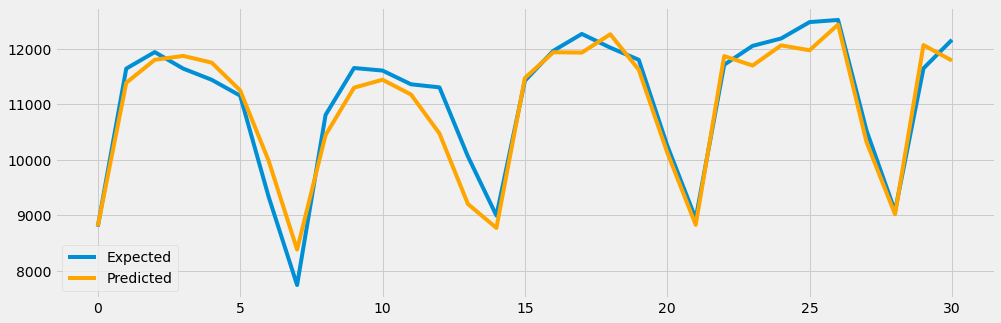

In [17]:
# plot expected vs predicted
plt.plot(y, label = 'Expected')
plt.plot(yhat, label = 'Predicted', color = 'orange')
plt.legend()
plt.show()

In [18]:
measures = get_measures(pd.Series(yhat), pd.Series(y))
df_measures = pd.DataFrame([measures])
df_measures

,erro,mae,mse,rmse,mape,smape
0,3.894151e+06,279.169271,125617.787623,354.425997,0.026016,2.614697


In [21]:
n_test = 31
fc = pd.DataFrame(list(zip(df.index[-n_test:], yhat, y)), columns = ["date", "forecast", "test"])
fc.set_index("date", inplace = True)
fc.to_csv("validation/xgboost_fc.csv")


,forecast,test
date,,
2022-05-01,8803.036033,8794.163125
2022-05-02,11388.489043,11643.821542
2022-05-03,11802.404352,11941.662583
2022-05-04,11872.868367,11643.861917
2022-05-05,11751.991816,11442.408417
2022-05-06,11250.853502,11156.521000
2022-05-07,9983.434201,9333.920083
2022-05-08,8381.637054,7742.394500
2022-05-09,10445.821730,10808.548667
